# Risk parity allocation

The purpose of this notebook is to show a basic application of risk modelling in creation and backtesting of **risk parity asset allocation trading strategy**. This notebook is based on a real-life coding test as part of a *job interview*.

Let's first import the packages we'll need, you should always be able to install packages by opening anaconda prompt as local admin and typing e.g. *conda install scipy*. Installig *arch* package might be more tricky, you can type: *conda install -c bashtage arch*

In [1]:
import pandas as pd
import numpy as np
from numpy import diag
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import scipy.cluster.hierarchy as sch
from datetime import date
from arch import arch_model
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.stats import norm

As next, let's define a few functions:

In [2]:
# Compute the inverse-variance portfolio
def getIVP(cov, **kargs):
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

The following gives portfolio variance as $$\sigma^2_p = w'\Sigma w$$, where $w$ is the vector of weights (your portfolio), and $\Sigma$ is a covariance matrix of your assets returns. ~~np.matrix~~ is deprecated, please try to replace this in your code as an exercise. Numpy vectors in code are usually horizontal, so the transposes work opposite as we're used to.

In [3]:
 # risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

Computing risk contribution per asset is easy, you have to take derivative of portfolio risk with respect to $w$, which is $\Sigma w$ and multiply this by $w$ elementwise. Then you can divide by the overall portfolio variance $\sigma^2_p$ to get vector of risk contributions. We also include the risk budget objective function and other definitions.

In [4]:
def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance matrix
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

def max_drawdown(X):
    mdd = 0
    peak = X[0]
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd   

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar


def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()


def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #dn = sch.dendrogram(link, labels=cov.index.values, label_rotation=90)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

# 1: load and prepare the data, compute excess returns

In [7]:
    data = pd.read_excel('Data RP Model.xlsx', skiprows=8,index_col=0, parse_dates=True)
    N_assets = data.shape[1]-1
    rets = data[1:] / data[:-1].values - 1
    X = np.concatenate((np.c_[rets.iloc[:,1:-1]] - np.c_[rets.iloc[:,0]],np.c_[rets.iloc[:,-1]]),axis=1)    # computing excess returns assuming CMCI is excess return already
    retx=pd.DataFrame(X, columns=rets.iloc[:,1:].columns, index=rets.index)
    # subsample to weekly data, which we'll use for the CORR matrix as well as for the backtest
    data_weekly = data.resample('W-WED').last()
    data_weekly.index = data_weekly.index.to_series().replace({data_weekly.index[-1]: data.index[-1]}) # replace last date with a valid date
    rets_W = data_weekly[1:] / data_weekly[:-1].values - 1
    X = np.concatenate((np.c_[rets_W.iloc[:,1:-1]] - np.c_[rets_W.iloc[:,0]],np.c_[rets_W.iloc[:,-1]]),axis=1)    # assuming CMCI is excess return and rest have to be made
    retx_W=pd.DataFrame(X, columns=rets_W.iloc[:,1:].columns, index=rets_W.index)

Create clusters based on the SAA, compute both daily and weekly returns. Weekly optimization could still be on a higher frequency of optimization for this type of strategies.

 # 2: create clusters based on the SAA

In [12]:
N_clusters = 3
w_clusters = np.array([[0.55,0.21,0.24],[0.4,0.35,0.25],[0.6,0.1,0.3]]) # asset weights in each cluster: equities, bonds, inflation
# daily    
retx_clusters = pd.DataFrame(columns=['cluster_Equities', 'cluster_Bonds', 'cluster_Inflation'])
retx_clusters['cluster_Equities']=\
(retx.loc[:,['US S&P 500', 'Euro Stoxx 50', 'Australia ASX 200']]*w_clusters[0,:]).sum(axis=1)
retx_clusters['cluster_Bonds']=\
(retx.loc[:,['US 10Y Total Return Index', 'Germany 10Y Total Return Index','Australia 10Y Total Return Index']]*w_clusters[1,:]).sum(axis=1)
retx_clusters['cluster_Inflation']=\
(retx.loc[:,['US Inflation Linked Bonds', 'Gold','CMCI Excess Return Index']]*w_clusters[2,:]).sum(axis=1)
# weekly
retx_clusters_W = pd.DataFrame(columns=['cluster_Equities', 'cluster_Bonds', 'cluster_Inflation'])
retx_clusters_W['cluster_Equities']=\
(retx_W.loc[:,['US S&P 500', 'Euro Stoxx 50', 'Australia ASX 200']]*w_clusters[0,:]).sum(axis=1)
retx_clusters_W['cluster_Bonds']=\
(retx_W.loc[:,['US 10Y Total Return Index', 'Germany 10Y Total Return Index','Australia 10Y Total Return Index']]*w_clusters[1,:]).sum(axis=1)
retx_clusters_W['cluster_Inflation']=\
(retx_W.loc[:,['US Inflation Linked Bonds', 'Gold','CMCI Excess Return Index']]*w_clusters[2,:]).sum(axis=1)

Let's first try to manage the equities cluster by decreasing allocation when the volatility is high and decreasing allocation when volatility is low.

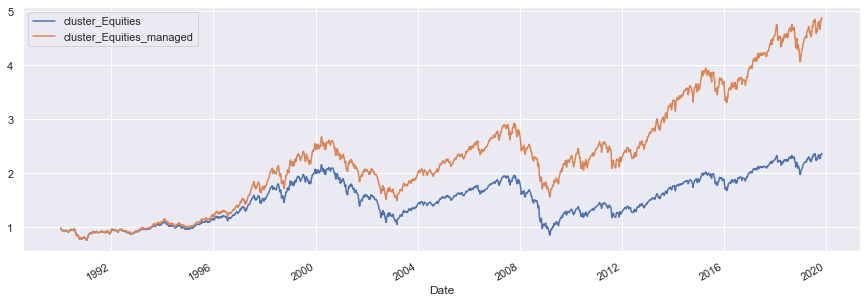

In [13]:
    gearing = retx_clusters['cluster_Equities'].rolling(260,center=False).mean()/retx_clusters['cluster_Equities'].rolling(260,center=False).std()
    gearing = gearing.shift(1)  # only use the gearing from the past period
    gearing.fillna(0,inplace=True)
    gearing_W = retx_clusters_W['cluster_Equities'].rolling(52,center=False).mean()/retx_clusters_W['cluster_Equities'].rolling(52,center=False).std()
    gearing = gearing.shift(1)
    gearing_W.fillna(0,inplace=True)
    retx_clusters['cluster_Equities_managed']=retx_clusters['cluster_Equities']*(1+gearing)
    retx_clusters_W['cluster_Equities_managed']=retx_clusters_W['cluster_Equities']*(1+gearing_W)
    sns.set(rc={'figure.figsize':(15, 5)})
    (1+retx_clusters_W[['cluster_Equities','cluster_Equities_managed']]).cumprod(axis=0).plot()
    retx_clusters_W.drop(columns=['cluster_Equities'],inplace=True)
    retx_clusters.drop(columns=['cluster_Equities'],inplace=True)

# 3: compute time series of volatilities and correlations, and the resulting covariance matrix 

Next, let's compute rolling correlations matrix $R_t$ and diagonal matrix of volatilities $D_t$. These we can then combine into overall covariance matrix $\Sigma_t = D_t R_t D_t$. We say correlations are more stable and capturing more recent volatility relevant events more important, so lags for correlations are longer (2 years) than for volatilities (100 days). You can replace this part by EWMA covariance matrix or experiment with DCC model.

1990-01-10 00:00:00
1990-01-17 00:00:00
1990-01-24 00:00:00
1990-01-31 00:00:00
1990-02-07 00:00:00
1990-02-14 00:00:00
1990-02-21 00:00:00
1990-02-28 00:00:00
1990-03-07 00:00:00
1990-03-14 00:00:00
1990-03-21 00:00:00
1990-03-28 00:00:00
1990-04-04 00:00:00
1990-04-11 00:00:00
1990-04-18 00:00:00
1990-04-25 00:00:00
1990-05-02 00:00:00
1990-05-09 00:00:00
1990-05-16 00:00:00
1990-05-23 00:00:00
1990-05-30 00:00:00
1990-06-06 00:00:00
1990-06-13 00:00:00
1990-06-20 00:00:00
1990-06-27 00:00:00
1990-07-04 00:00:00
1990-07-11 00:00:00
1990-07-18 00:00:00
1990-07-25 00:00:00
1990-08-01 00:00:00
1990-08-08 00:00:00
1990-08-15 00:00:00
1990-08-22 00:00:00
1990-08-29 00:00:00
1990-09-05 00:00:00
1990-09-12 00:00:00
1990-09-19 00:00:00
1990-09-26 00:00:00
1990-10-03 00:00:00
1990-10-10 00:00:00
1990-10-17 00:00:00
1990-10-24 00:00:00
1990-10-31 00:00:00
1990-11-07 00:00:00
1990-11-14 00:00:00
1990-11-21 00:00:00
1990-11-28 00:00:00
1990-12-05 00:00:00
1990-12-12 00:00:00
1990-12-19 00:00:00


1998-12-02 00:00:00
1998-12-09 00:00:00
1998-12-16 00:00:00
1998-12-23 00:00:00
1998-12-30 00:00:00
1999-01-06 00:00:00
1999-01-13 00:00:00
1999-01-20 00:00:00
1999-01-27 00:00:00
1999-02-03 00:00:00
1999-02-10 00:00:00
1999-02-17 00:00:00
1999-02-24 00:00:00
1999-03-03 00:00:00
1999-03-10 00:00:00
1999-03-17 00:00:00
1999-03-24 00:00:00
1999-03-31 00:00:00
1999-04-07 00:00:00
1999-04-14 00:00:00
1999-04-21 00:00:00
1999-04-28 00:00:00
1999-05-05 00:00:00
1999-05-12 00:00:00
1999-05-19 00:00:00
1999-05-26 00:00:00
1999-06-02 00:00:00
1999-06-09 00:00:00
1999-06-16 00:00:00
1999-06-23 00:00:00
1999-06-30 00:00:00
1999-07-07 00:00:00
1999-07-14 00:00:00
1999-07-21 00:00:00
1999-07-28 00:00:00
1999-08-04 00:00:00
1999-08-11 00:00:00
1999-08-18 00:00:00
1999-08-25 00:00:00
1999-09-01 00:00:00
1999-09-08 00:00:00
1999-09-15 00:00:00
1999-09-22 00:00:00
1999-09-29 00:00:00
1999-10-06 00:00:00
1999-10-13 00:00:00
1999-10-20 00:00:00
1999-10-27 00:00:00
1999-11-03 00:00:00
1999-11-10 00:00:00


2006-11-08 00:00:00
2006-11-15 00:00:00
2006-11-22 00:00:00
2006-11-29 00:00:00
2006-12-06 00:00:00
2006-12-13 00:00:00
2006-12-20 00:00:00
2006-12-27 00:00:00
2007-01-03 00:00:00
2007-01-10 00:00:00
2007-01-17 00:00:00
2007-01-24 00:00:00
2007-01-31 00:00:00
2007-02-07 00:00:00
2007-02-14 00:00:00
2007-02-21 00:00:00
2007-02-28 00:00:00
2007-03-07 00:00:00
2007-03-14 00:00:00
2007-03-21 00:00:00
2007-03-28 00:00:00
2007-04-04 00:00:00
2007-04-11 00:00:00
2007-04-18 00:00:00
2007-04-25 00:00:00
2007-05-02 00:00:00
2007-05-09 00:00:00
2007-05-16 00:00:00
2007-05-23 00:00:00
2007-05-30 00:00:00
2007-06-06 00:00:00
2007-06-13 00:00:00
2007-06-20 00:00:00
2007-06-27 00:00:00
2007-07-04 00:00:00
2007-07-11 00:00:00
2007-07-18 00:00:00
2007-07-25 00:00:00
2007-08-01 00:00:00
2007-08-08 00:00:00
2007-08-15 00:00:00
2007-08-22 00:00:00
2007-08-29 00:00:00
2007-09-05 00:00:00
2007-09-12 00:00:00
2007-09-19 00:00:00
2007-09-26 00:00:00
2007-10-03 00:00:00
2007-10-10 00:00:00
2007-10-17 00:00:00


2016-09-14 00:00:00
2016-09-21 00:00:00
2016-09-28 00:00:00
2016-10-05 00:00:00
2016-10-12 00:00:00
2016-10-19 00:00:00
2016-10-26 00:00:00
2016-11-02 00:00:00
2016-11-09 00:00:00
2016-11-16 00:00:00
2016-11-23 00:00:00
2016-11-30 00:00:00
2016-12-07 00:00:00
2016-12-14 00:00:00
2016-12-21 00:00:00
2016-12-28 00:00:00
2017-01-04 00:00:00
2017-01-11 00:00:00
2017-01-18 00:00:00
2017-01-25 00:00:00
2017-02-01 00:00:00
2017-02-08 00:00:00
2017-02-15 00:00:00
2017-02-22 00:00:00
2017-03-01 00:00:00
2017-03-08 00:00:00
2017-03-15 00:00:00
2017-03-22 00:00:00
2017-03-29 00:00:00
2017-04-05 00:00:00
2017-04-12 00:00:00
2017-04-19 00:00:00
2017-04-26 00:00:00
2017-05-03 00:00:00
2017-05-10 00:00:00
2017-05-17 00:00:00
2017-05-24 00:00:00
2017-05-31 00:00:00
2017-06-07 00:00:00
2017-06-14 00:00:00
2017-06-21 00:00:00
2017-06-28 00:00:00
2017-07-05 00:00:00
2017-07-12 00:00:00
2017-07-19 00:00:00
2017-07-26 00:00:00
2017-08-02 00:00:00
2017-08-09 00:00:00
2017-08-16 00:00:00
2017-08-23 00:00:00


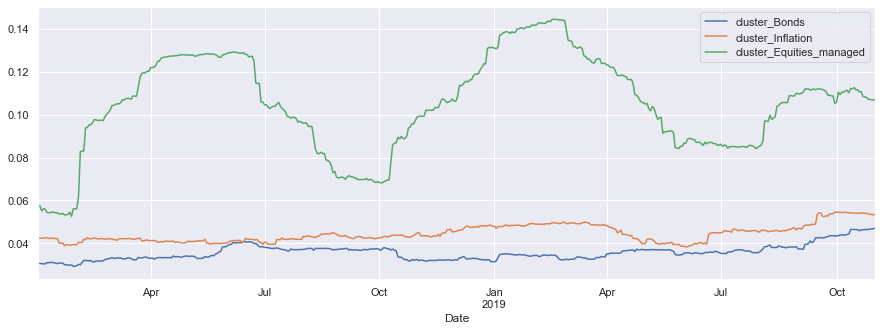

In [11]:
rolling_corr = retx_clusters_W.rolling(104,center=False).corr()     # 2 years rolling correlation
rolling_vol = retx_clusters.rolling(100,center=False).std()*np.sqrt(260)    # 100 days rolling vol (6b provides GARCH(1,1) alternative)
rolling_cov = pd.DataFrame(columns= rolling_corr.columns,index=rolling_corr.index)
rolling_vol[rolling_vol.index>'2018-01-01'].plot()

# alternatively, estimate COV using Ledoit, Wolf 2018
for d in rolling_corr.unstack().index:      # weekly
    print(d)
    rolling_cov.loc[d] = diag(rolling_vol.loc[d]) @ np.c_[rolling_corr.loc[d]] @ diag(rolling_vol.loc[d])   # cov from corr and vol


 # 4: optimize to achieve risk parity portfolio weekly

Let's now optimize the weights such that we have a risk parity portfolio every week. $w^* = argmin(\sum^{assets}(MRC w'-risk target)^2)$

[[0.33333333 0.33333333 0.33333333]]
1992-01-01 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.192689612981284e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1992-01-08 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.336161686931357e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1992-01-15 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.679833716400755e-14
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
1992-01-22 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.494156529190513e-13
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1992-01-29 00:00:00
Optimizatio

1992-09-16 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.9229874578673754e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1992-09-23 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.9317419401492866e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1992-09-30 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.349291027983782e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1992-10-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.6721108520375635e-15
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1992-10-14 00:00:00
Optimization terminated successfully    (Exit

            Gradient evaluations: 12
1993-06-09 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.772353833437485e-13
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
1993-06-16 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5266546884672848e-17
            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 12
1993-06-23 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.9374360221609814e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1993-06-30 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.827714301694357e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1993-07-07 00:00:00
Optimizat

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.093363879723646e-13
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1994-03-09 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.8408324328274515e-13
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1994-03-16 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.789266812987883e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1994-03-23 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.364111180715826e-15
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1994-03-30 00:00:00
Optimization terminated successfully    (Exit mode 0)
            C

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.2493329794482073e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1994-11-23 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.570067096368356e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1994-11-30 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.8571159281620443e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1994-12-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0711531436631749e-15
            Iterations: 15
            Function evaluations: 61
            Gradient evaluations: 15
1994-12-14 00:00:00
Optimization terminated successfully    (Exit mode 0)
           

            Current function value: 1.2354282416324787e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1995-08-16 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.00074495237092e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1995-08-23 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.11672974927418e-13
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
1995-08-30 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.869762250569658e-14
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
1995-09-06 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.535770559188152e-14
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.19072369504425e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1996-05-29 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.535535938232308e-13
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
1996-06-05 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3127045086352754e-14
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
1996-06-12 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.5570922225544435e-15
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
1996-06-19 00:00:00
Optimization terminated successfully    (Exit mode 0)
            C

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1517579436248134e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1997-02-05 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3497596396276645e-16
            Iterations: 13
            Function evaluations: 53
            Gradient evaluations: 13
1997-02-12 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0176520708932468e-13
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1997-02-19 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4788747735427052e-13
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1997-02-26 00:00:00
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0627233895725893e-15
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
1997-12-10 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.948590308986137e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1997-12-17 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.8927399171062167e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1997-12-24 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.7850894561007725e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1997-12-31 00:00:00
Optimization terminated successfully    (Exit mode 0)
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.7323558763417743e-14
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
1998-09-16 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.543390569898023e-15
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1998-09-23 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7228830052772626e-13
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
1998-09-30 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.4861376906905834e-13
            Iterations: 17
            Function evaluations: 68
            Gradient evaluations: 17
1998-10-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
           

            Function evaluations: 60
            Gradient evaluations: 15
1999-06-30 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.749441222519616e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1999-07-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1947097250906098e-15
            Iterations: 15
            Function evaluations: 61
            Gradient evaluations: 15
1999-07-14 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3180279601909936e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
1999-07-21 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4898987093256454e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluat

            Current function value: 5.830169043113149e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2000-04-19 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.752415132308799e-19
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2000-04-26 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0151161466677726e-18
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2000-05-03 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.229782335636875e-14
            Iterations: 17
            Function evaluations: 68
            Gradient evaluations: 17
2000-05-10 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.92228963422131e-14
          

            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 12
2001-01-31 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.64093771400364e-19
            Iterations: 11
            Function evaluations: 45
            Gradient evaluations: 11
2001-02-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5410391881996968e-13
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2001-02-14 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.745790413478354e-13
            Iterations: 10
            Function evaluations: 40
            Gradient evaluations: 10
2001-02-21 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.162185085450703e-13
            Iterations: 14
            Function evaluations: 56
    

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2131448306577881e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2001-10-17 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.730378625619861e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2001-10-24 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3376466325604736e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2001-10-31 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5215048773618787e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2001-11-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1737439706919185e-13
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2002-07-17 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.9535536153674645e-14
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2002-07-24 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.165621550563859e-14
            Iterations: 17
            Function evaluations: 68
            Gradient evaluations: 17
2002-07-31 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.06630364112353e-14
            Iterations: 18
            Function evaluations: 73
            Gradient evaluations: 18
2002-08-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            C

            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2003-04-23 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.6339119399456139e-16
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2003-04-30 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.5180572261349556e-18
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2003-05-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.694970626861216e-14
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2003-05-14 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.56208510868607e-14
            Iterations: 14
            Function evaluations: 56
   

            Gradient evaluations: 12
2004-02-18 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0598893596557128e-15
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2004-02-25 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.333104709720095e-15
            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 12
2004-03-03 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.9622221539046756e-17
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2004-03-10 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.701001414049474e-17
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2004-03-17 00:00:00
Optimizat

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.649385677407158e-16
            Iterations: 13
            Function evaluations: 53
            Gradient evaluations: 13
2004-11-03 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1358560278834573e-18
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2004-11-10 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0590122802948228e-17
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2004-11-17 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2083843382632307e-16
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2004-11-24 00:00:00
Optimization terminated successfully    (Exit mode 0)
           

            Gradient evaluations: 15
2005-08-24 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.191311198185259e-17
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2005-08-31 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.481395920280096e-16
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2005-09-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.039059994351743e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2005-09-14 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.337127818573292e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2005-09-21 00:00:00
Optimizatio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.46373616829569e-15
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2006-06-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.59943101253836e-14
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2006-06-14 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.3704248742457794e-16
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2006-06-21 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.9805032217763295e-18
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2006-06-28 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Cu

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.1856111918158814e-18
            Iterations: 13
            Function evaluations: 53
            Gradient evaluations: 13
2007-02-21 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.665141694990747e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2007-02-28 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.6184590834622e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2007-03-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.440398004272363e-16
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2007-03-14 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Cur

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.099973669917104e-14
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2007-11-28 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.47947419521999e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2007-12-05 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.19272274039664e-17
            Iterations: 14
            Function evaluations: 57
            Gradient evaluations: 14
2007-12-12 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.389559054725997e-14
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2007-12-19 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Curr

            Gradient evaluations: 13
2008-09-17 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.169517047350996e-14
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2008-09-24 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.71836259819366e-14
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2008-10-01 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7737222769127358e-16
            Iterations: 13
            Function evaluations: 53
            Gradient evaluations: 13
2008-10-08 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.858393975266761e-16
            Iterations: 13
            Function evaluations: 53
            Gradient evaluations: 13
2008-10-15 00:00:00
Optimizatio

            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 12
2009-07-08 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0627638479291487e-16
            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 12
2009-07-15 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5257091907427098e-13
            Iterations: 11
            Function evaluations: 44
            Gradient evaluations: 11
2009-07-22 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.774882505210594e-13
            Iterations: 11
            Function evaluations: 44
            Gradient evaluations: 11
2009-07-29 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3191953028302643e-13
            Iterations: 11
            Function evaluations: 44
 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.7397840637142767e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2010-04-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1406959951116095e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2010-04-14 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9236399517228628e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2010-04-21 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.774970926308187e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2010-04-28 00:00:00
Optimization terminated successfully    (Exit mode 0)
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.8901535256311272e-14
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2011-01-19 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2941139005520915e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2011-01-26 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.488377757589502e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2011-02-02 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.010938506979295e-15
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2011-02-09 00:00:00
Optimization terminated successfully    (Exit mode 0)
            

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.8379353108681018e-14
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2011-10-19 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0754538950777486e-14
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2011-10-26 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.9972077910466903e-16
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2011-11-02 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.8926493364491852e-16
            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 12
2011-11-09 00:00:00
Optimization terminated successfully    (Exit mode 0)
          

            Gradient evaluations: 14
2012-07-25 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.279722644922984e-17
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2012-08-01 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.0019895749247355e-13
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2012-08-08 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.863181481262721e-16
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2012-08-15 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.428046294588879e-15
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2012-08-22 00:00:00
Optimizati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.352628808361489e-15
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
2013-05-01 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.423340851956072e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2013-05-08 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3166927937929958e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2013-05-15 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.813024381645917e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2013-05-22 00:00:00
Optimization terminated successfully    (Exit mode 0)
            C

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.6092321451822373e-16
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2014-02-26 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.657046957027464e-16
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2014-03-05 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1902835967117674e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2014-03-12 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.208718251131521e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2014-03-19 00:00:00
Optimization terminated successfully    (Exit mode 0)
            

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0546944254033674e-16
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2014-12-10 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.796942006769372e-16
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2014-12-17 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4188593299876349e-16
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2014-12-24 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.832395581927898e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2014-12-31 00:00:00
Optimization terminated successfully    (Exit mode 0)
            

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.541106179770566e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2015-08-26 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.172501853279758e-15
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2015-09-02 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.618097146483302e-17
            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 12
2015-09-09 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.323092391183251e-15
            Iterations: 11
            Function evaluations: 44
            Gradient evaluations: 11
2015-09-16 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Cu

            Current function value: 8.316885634051493e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2016-05-11 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.056508807113924e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2016-05-18 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.310886366928898e-14
            Iterations: 14
            Function evaluations: 57
            Gradient evaluations: 14
2016-05-25 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.2265520675519005e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2016-06-01 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.7299863082696336e-14
        

            Gradient evaluations: 15
2017-03-01 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.337535767742877e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2017-03-08 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.568410017412313e-15
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2017-03-15 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.0568769119736658e-14
            Iterations: 12
            Function evaluations: 48
            Gradient evaluations: 12
2017-03-22 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.22673865522622e-13
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2017-03-29 00:00:00
Optimizatio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0358999895222383e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2017-12-27 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.08774257858047e-16
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2018-01-03 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.1832625381851246e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2018-01-10 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.692888824099629e-19
            Iterations: 14
            Function evaluations: 56
            Gradient evaluations: 14
2018-01-17 00:00:00
Optimization terminated successfully    (Exit mode 0)
            C

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1002956291818955e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2018-10-03 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0013008279603267e-14
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2018-10-10 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.398760413834058e-17
            Iterations: 16
            Function evaluations: 64
            Gradient evaluations: 16
2018-10-17 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.813462212320355e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2018-10-24 00:00:00
Optimization terminated successfully    (Exit mode 0)
            

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.423228636021553e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2019-07-17 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3265256813147047e-13
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2019-07-24 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.595952281360503e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2019-07-31 00:00:00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.916811282026509e-14
            Iterations: 15
            Function evaluations: 60
            Gradient evaluations: 15
2019-08-07 00:00:00
Optimization terminated successfully    (Exit mode 0)
            C

<AxesSubplot:xlabel='Date'>

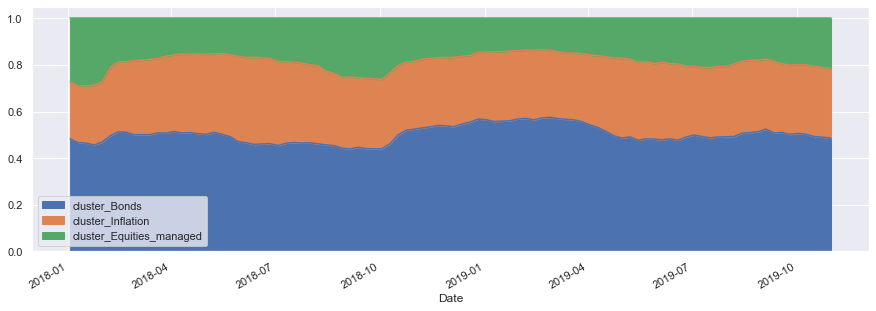

In [14]:
    w_opt = pd.DataFrame(columns=retx_clusters_W.columns, index=retx_clusters_W.index)
    risk_budget = np.ones([1,N_clusters])/N_clusters    # your risk budget percent of total portfolio risk (equal risk)
    print(risk_budget)
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
    {'type': 'ineq', 'fun': long_only_constraint})
    w0 = risk_budget
    for d in rolling_cov.loc[rolling_cov['cluster_Bonds'].notna(),:].unstack().index:
        print(d)       
        V = rolling_cov.loc[d].values
        res= minimize(risk_budget_objective, w0, args=[V,w0], method='SLSQP',constraints=cons, options={'disp': True,'ftol': 1e-12})
        w_opt.loc[d,:] = res.x.astype(float)
    
    sns.set(rc={'figure.figsize':(15, 5)})
    w_opt.loc[w_opt.index>'2018-01-01'].plot.area()

Plot the optimal weights over whole time period

<AxesSubplot:xlabel='Date'>

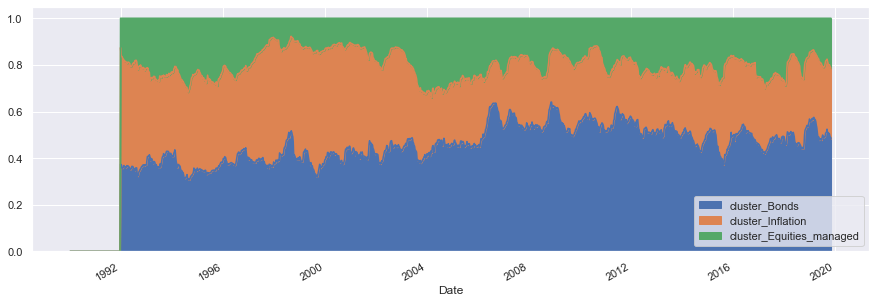

In [15]:
w_opt.plot.area()

# 5: back test the resulting weights
## 5a: verify risk parity and check against the realization

In [18]:
    RC_in = pd.DataFrame(columns=retx_clusters_W.columns, index=retx_clusters_W.index)
    RC_out = pd.DataFrame(columns=retx_clusters_W.columns, index=retx_clusters_W.index)
    vol_in = pd.DataFrame(columns=['vol_in'], index=retx_clusters_W.index)
    vol_out = pd.DataFrame(columns=['vol_out'], index=retx_clusters_W.index)
    retx_W_BT = pd.DataFrame((w_opt.values * retx_clusters_W.values).sum(axis=1), index=retx_clusters_W.index,
                             columns=['returns'])
    BT_std_emp = retx_W_BT.rolling(52,center=False).std()*np.sqrt(52)
    BT_std_emp.rename(columns={'returns':'rolling BT vol'},inplace=True)
    vol_target = 0.04

Let's compute in-sample risk contributions and corresponding out of sample risk contributions.

In [19]:
for d in rolling_cov.loc[rolling_cov['cluster_Bonds'].notna(),:].unstack().index:   # weekly
    print(d)       
    V = rolling_cov.loc[d].values
    w = w_opt.loc[d].values
    w_past = w_opt.iloc[w_opt.index.get_loc(d)-1].values
    RC_in.loc[d] = calculate_risk_contribution(w,V).T
    vol_in.loc[d] = (RC_in.iloc[RC_in.index.get_loc(d)-1] * vol_target / sum(RC_in.iloc[RC_in.index.get_loc(d)-1])).sum()
    RC_out.loc[d] = calculate_risk_contribution(w_past,V).T
    vol_out.loc[d] = (RC_out.loc[d] * vol_target / sum(RC_in.iloc[RC_in.index.get_loc(d)-1])).sum()

1992-01-01 00:00:00
1992-01-08 00:00:00
1992-01-15 00:00:00
1992-01-22 00:00:00
1992-01-29 00:00:00
1992-02-05 00:00:00
1992-02-12 00:00:00
1992-02-19 00:00:00
1992-02-26 00:00:00
1992-03-04 00:00:00
1992-03-11 00:00:00
1992-03-18 00:00:00
1992-03-25 00:00:00
1992-04-01 00:00:00
1992-04-08 00:00:00
1992-04-15 00:00:00
1992-04-22 00:00:00
1992-04-29 00:00:00
1992-05-06 00:00:00
1992-05-13 00:00:00
1992-05-20 00:00:00
1992-05-27 00:00:00
1992-06-03 00:00:00
1992-06-10 00:00:00
1992-06-17 00:00:00
1992-06-24 00:00:00
1992-07-01 00:00:00
1992-07-08 00:00:00
1992-07-15 00:00:00
1992-07-22 00:00:00
1992-07-29 00:00:00
1992-08-05 00:00:00
1992-08-12 00:00:00
1992-08-19 00:00:00
1992-08-26 00:00:00
1992-09-02 00:00:00
1992-09-09 00:00:00
1992-09-16 00:00:00
1992-09-23 00:00:00
1992-09-30 00:00:00
1992-10-07 00:00:00
1992-10-14 00:00:00
1992-10-21 00:00:00
1992-10-28 00:00:00
1992-11-04 00:00:00
1992-11-11 00:00:00
1992-11-18 00:00:00
1992-11-25 00:00:00
1992-12-02 00:00:00
1992-12-09 00:00:00


2000-06-28 00:00:00
2000-07-05 00:00:00
2000-07-12 00:00:00
2000-07-19 00:00:00
2000-07-26 00:00:00
2000-08-02 00:00:00
2000-08-09 00:00:00
2000-08-16 00:00:00
2000-08-23 00:00:00
2000-08-30 00:00:00
2000-09-06 00:00:00
2000-09-13 00:00:00
2000-09-20 00:00:00
2000-09-27 00:00:00
2000-10-04 00:00:00
2000-10-11 00:00:00
2000-10-18 00:00:00
2000-10-25 00:00:00
2000-11-01 00:00:00
2000-11-08 00:00:00
2000-11-15 00:00:00
2000-11-22 00:00:00
2000-11-29 00:00:00
2000-12-06 00:00:00
2000-12-13 00:00:00
2000-12-20 00:00:00
2000-12-27 00:00:00
2001-01-03 00:00:00
2001-01-10 00:00:00
2001-01-17 00:00:00
2001-01-24 00:00:00
2001-01-31 00:00:00
2001-02-07 00:00:00
2001-02-14 00:00:00
2001-02-21 00:00:00
2001-02-28 00:00:00
2001-03-07 00:00:00
2001-03-14 00:00:00
2001-03-21 00:00:00
2001-03-28 00:00:00
2001-04-04 00:00:00
2001-04-11 00:00:00
2001-04-18 00:00:00
2001-04-25 00:00:00
2001-05-02 00:00:00
2001-05-09 00:00:00
2001-05-16 00:00:00
2001-05-23 00:00:00
2001-05-30 00:00:00
2001-06-06 00:00:00


2008-12-17 00:00:00
2008-12-24 00:00:00
2008-12-31 00:00:00
2009-01-07 00:00:00
2009-01-14 00:00:00
2009-01-21 00:00:00
2009-01-28 00:00:00
2009-02-04 00:00:00
2009-02-11 00:00:00
2009-02-18 00:00:00
2009-02-25 00:00:00
2009-03-04 00:00:00
2009-03-11 00:00:00
2009-03-18 00:00:00
2009-03-25 00:00:00
2009-04-01 00:00:00
2009-04-08 00:00:00
2009-04-15 00:00:00
2009-04-22 00:00:00
2009-04-29 00:00:00
2009-05-06 00:00:00
2009-05-13 00:00:00
2009-05-20 00:00:00
2009-05-27 00:00:00
2009-06-03 00:00:00
2009-06-10 00:00:00
2009-06-17 00:00:00
2009-06-24 00:00:00
2009-07-01 00:00:00
2009-07-08 00:00:00
2009-07-15 00:00:00
2009-07-22 00:00:00
2009-07-29 00:00:00
2009-08-05 00:00:00
2009-08-12 00:00:00
2009-08-19 00:00:00
2009-08-26 00:00:00
2009-09-02 00:00:00
2009-09-09 00:00:00
2009-09-16 00:00:00
2009-09-23 00:00:00
2009-09-30 00:00:00
2009-10-07 00:00:00
2009-10-14 00:00:00
2009-10-21 00:00:00
2009-10-28 00:00:00
2009-11-04 00:00:00
2009-11-11 00:00:00
2009-11-18 00:00:00
2009-11-25 00:00:00


2017-02-01 00:00:00
2017-02-08 00:00:00
2017-02-15 00:00:00
2017-02-22 00:00:00
2017-03-01 00:00:00
2017-03-08 00:00:00
2017-03-15 00:00:00
2017-03-22 00:00:00
2017-03-29 00:00:00
2017-04-05 00:00:00
2017-04-12 00:00:00
2017-04-19 00:00:00
2017-04-26 00:00:00
2017-05-03 00:00:00
2017-05-10 00:00:00
2017-05-17 00:00:00
2017-05-24 00:00:00
2017-05-31 00:00:00
2017-06-07 00:00:00
2017-06-14 00:00:00
2017-06-21 00:00:00
2017-06-28 00:00:00
2017-07-05 00:00:00
2017-07-12 00:00:00
2017-07-19 00:00:00
2017-07-26 00:00:00
2017-08-02 00:00:00
2017-08-09 00:00:00
2017-08-16 00:00:00
2017-08-23 00:00:00
2017-08-30 00:00:00
2017-09-06 00:00:00
2017-09-13 00:00:00
2017-09-20 00:00:00
2017-09-27 00:00:00
2017-10-04 00:00:00
2017-10-11 00:00:00
2017-10-18 00:00:00
2017-10-25 00:00:00
2017-11-01 00:00:00
2017-11-08 00:00:00
2017-11-15 00:00:00
2017-11-22 00:00:00
2017-11-29 00:00:00
2017-12-06 00:00:00
2017-12-13 00:00:00
2017-12-20 00:00:00
2017-12-27 00:00:00
2018-01-03 00:00:00
2018-01-10 00:00:00


Let's plot in-sample and out-of-sample sums of risk contributions. It seems we're doing a pretty decent job in managing equal risk contributions (using our rolling covariance matrix).

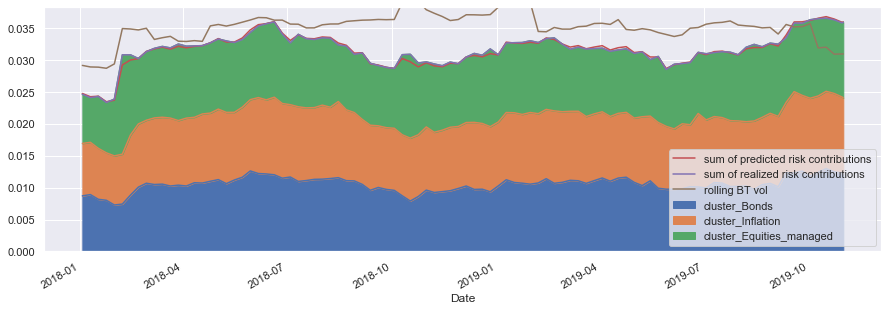

In [20]:
sns.set(rc={'figure.figsize':(15, 5)})
RC_out.loc[w_opt.index>'2018-01-01'].plot.area()
ax = RC_in.loc[w_opt.index>'2018-01-01'].sum(axis=1).plot(label='sum of predicted risk contributions')
RC_out.loc[w_opt.index>'2018-01-01'].sum(axis=1).plot(ax=ax,label='sum of realized risk contributions')
BT_std_emp.loc[w_opt.index>'2018-01-01'].plot(ax=ax,label='1 year rolling empirical vol annualized')
ax.legend()

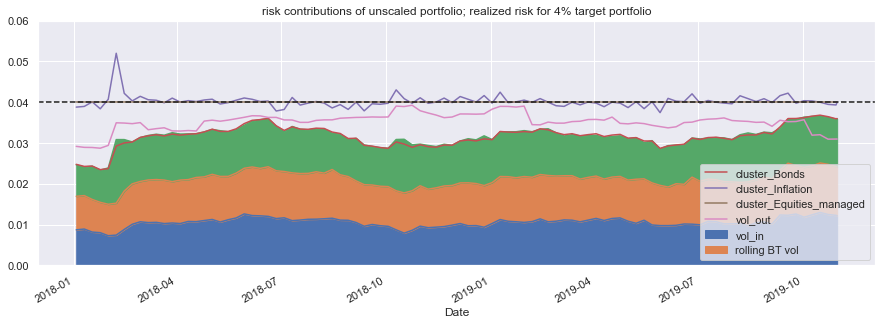

In [21]:
sns.set(rc={'figure.figsize':(15, 5)})
RC_out.loc[w_opt.index>'2018-01-01'].plot.area(title='risk contributions of unscaled portfolio; realized risk for 4% target portfolio')
ax = RC_in.loc[w_opt.index>'2018-01-01'].sum(axis=1).plot(ylim=[0,0.06])
vol_out.loc[w_opt.index>'2018-01-01'].plot(ax=ax)
vol_in.loc[w_opt.index>'2018-01-01'].plot(ax=ax)
BT_std_emp.loc[w_opt.index > '2018-01-01'].plot(ax=ax)
ax.axhline(vol_target, color='k', linestyle='--')

In [22]:
print('MRSE for the sample is: ' + str(np.sqrt(((vol_out-vol_target)**2).mean())))

MRSE for the sample is: vol_out    0.001611
dtype: float64


## 5b: compute performance

Let's plot performance chart

<AxesSubplot:xlabel='Date'>

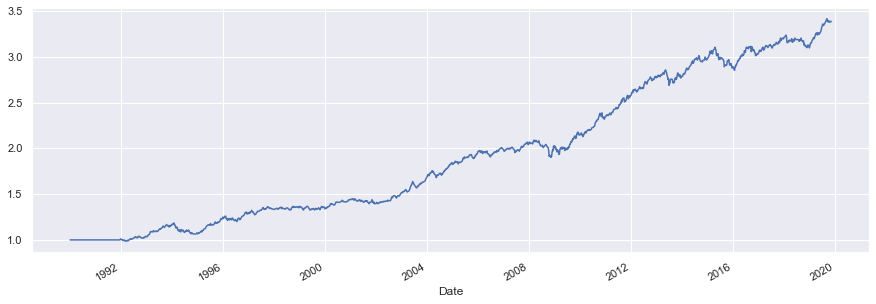

In [23]:
(1 + (w_opt * retx_clusters_W).sum(axis=1)).cumprod(axis=0).plot()

and turnover

<AxesSubplot:xlabel='Date'>

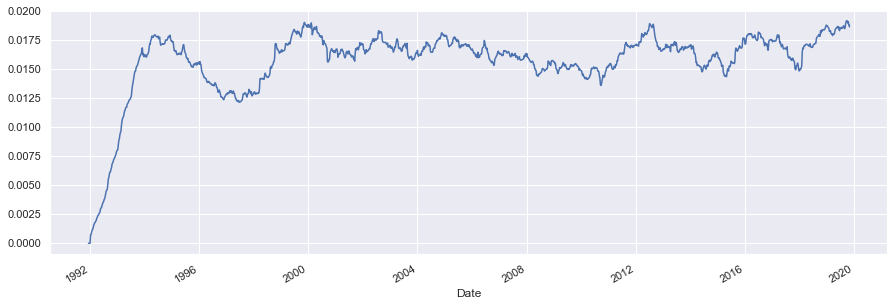

In [26]:
turnover = pd.DataFrame(abs(w_opt[1:].values-w_opt[:-1].values),index=retx_clusters_W.index[1:],columns=retx_clusters_W.columns)
turnover.sum(axis=1).rolling(100).mean().plot()

Let's compute some statistics on the back test performance.

In [27]:
def print_hist_stats(retx):
    mu = retx.mean() * 52
    sigma = retx.std() * np.sqrt(52)
    cumret = (1 + (retx).sum(axis=1)).cumprod(axis=0)
    ret_rolling_pa = np.log(cumret) - np.log(cumret.shift(52))

    print('mean excess return p.a.: ' + str(mu))
    print('volatility p.a.: ' + str(sigma))
    print('Sharpe p.a.: ' + str(mu / sigma))
    print('VaR 95%, normal: ' + str(norm.ppf(0.05, mu, sigma)) + ', vs empirical: ' + str(ret_rolling_pa.quantile(0.05)))
    print('max dradown: ' + str(max_drawdown(cumret)))

    return mu, sigma


print_hist_stats(retx_W_BT)
print_hist_stats(retx_W_BT.loc[retx_W_BT.index>'2018-01-01'])

mean excess return p.a.: returns    0.044635
dtype: float64
volatility p.a.: returns    0.043785
dtype: float64
Sharpe p.a.: returns    1.019414
dtype: float64
VaR 95%, normal: [-0.02738514], vs empirical: -0.032052570498371846
max dradown: 0.10313658023372359
mean excess return p.a.: returns    0.029757
dtype: float64
volatility p.a.: returns    0.035161
dtype: float64
Sharpe p.a.: returns    0.846304
dtype: float64
VaR 95%, normal: [-0.02807746], vs empirical: -0.02394716894689524
max dradown: 0.043466754476184914


(returns    0.029757
 dtype: float64,
 returns    0.035161
 dtype: float64)

<AxesSubplot:title={'center':'performance since 1.1.2018'}, xlabel='Date'>

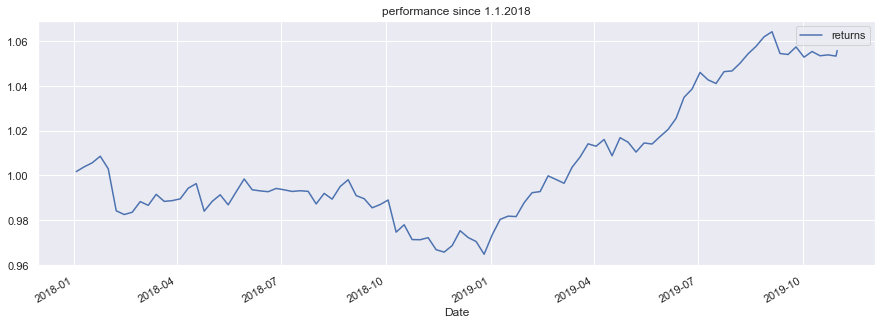

In [28]:
(1+retx_W_BT.loc[retx_W_BT.index>'2018-01-01']).cumprod(axis=0).plot(title = 'performance since 1.1.2018')

# 6 try some alternatives
## 6a: Alternative cluster formation- Marcos Lopez del Prado- hierarchical risk clustering gets us the following weights per one period

<ipython-input-4-f4df23d6bf90>:91: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist, 'single')


<AxesSubplot:>

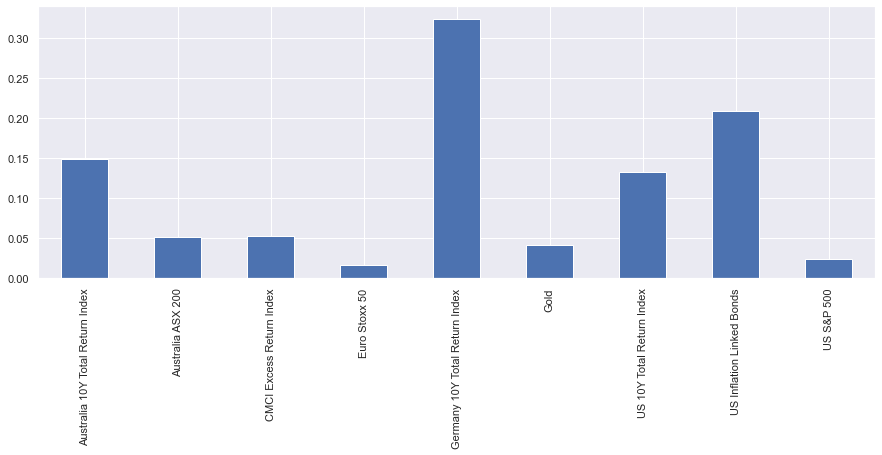

In [29]:
hrp = getHRP(retx.cov(), retx.corr())
hrp.plot.bar()

## 6b: Alternative volatility estimation by GARCH

let's first analyze returns and residuals of a GARCH(1,1) model applied to S&P 500.

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.434e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -343.5747431823322
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:             US S&P 500   R-squared:                      -0.002
Mean Model:             Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:                343.575
Distribution:                  Normal   AIC:                          -679.149
Method:            Maximum Likelihood   BIC:                          -668.729
                                        No. Observations:                  100
Date:                Sat, May 15 2021   Df Residuals:                       96
Time:                        17:29:29   Df Model:                            4
                                 Mean Mo

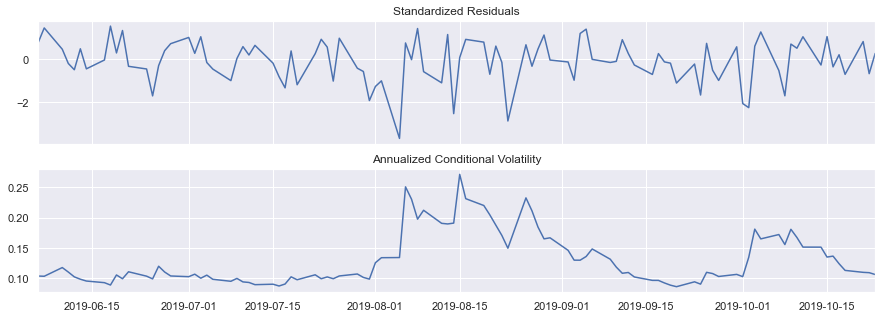

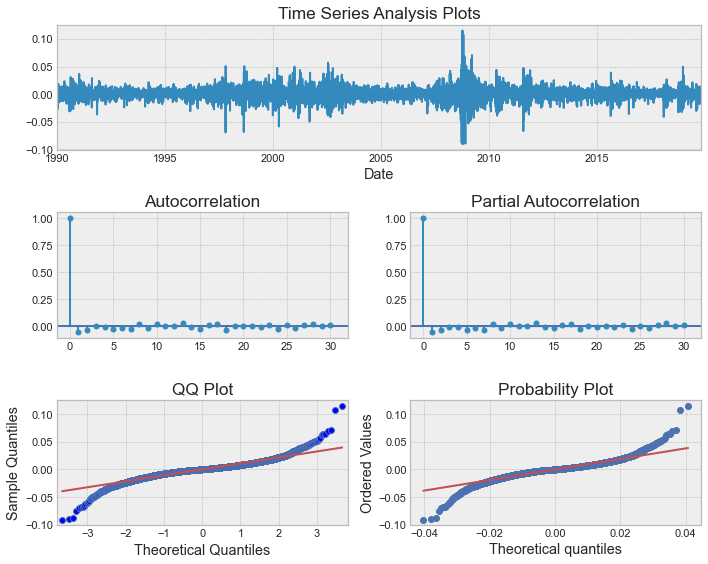

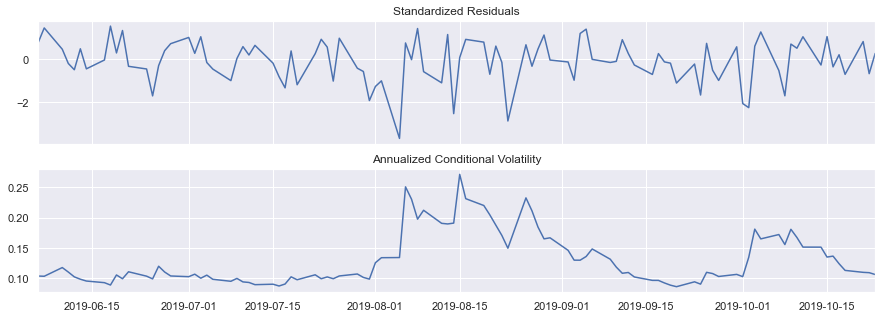

In [31]:
tsplot(retx['US S&P 500'], lags=30)  
res = arch_model(retx['US S&P 500'][-106:-6]).fit(update_freq=5)
print(res.summary)
res.plot(annualize='D')

Let's try to apply GARCH(1,1) to our clusters.

In [32]:
vol_forecast = np.ones([3,1])
res = arch_model(retx_clusters['cluster_Bonds'][-106:-6]).fit() # fits GARCH(1,1) as a standard
vol_forecast[0] = np.sqrt(res.forecast(horizon=5).variance.dropna().iloc[0,4])*np.sqrt(260) # computes a week ahead vol forecast
res = arch_model(retx_clusters['cluster_Inflation'][-106:-6]).fit() # fits GARCH(1,1) as a standard
vol_forecast[1] = np.sqrt(res.forecast(horizon=5).variance.dropna().iloc[0,4])*np.sqrt(260)
res = arch_model(retx_clusters['cluster_Equities_managed'][-106:-6]).fit() # fits GARCH(1,1) as a standard
vol_forecast[2] = np.sqrt(res.forecast(horizon=5).variance.dropna().iloc[0,4])*np.sqrt(260)
cov_forecast=diag(vol_forecast.flatten()) @ np.c_[rolling_corr.loc['2019-10-23'].values] @ diag(vol_forecast.flatten())   # cov from corr and vol
res= minimize(risk_budget_objective, w0, args=[cov_forecast,w0], method='SLSQP',constraints=cons, options={'disp': True,'ftol': 1e-12})
w_garch = res.x.astype(float)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 164081905101.46774
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4164887620.0817904
Iteration:      3,   Func. Count:     30,   Neg. LLF: 113076105.06564528
Iteration:      4,   Func. Count:     42,   Neg. LLF: 3042437.329416143
Optimization terminated successfully    (Exit mode 0)
            Current function value: -445.11201082830485
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 55850407.2114858
Iteration:      2,   Func. Count:     18,   Neg. LLF: 17095111516.649168
Optimization terminated successfully    (Exit mode 0)
            Current function value: -428.6420993990008
            Iterations: 2
            Function evaluations: 28
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 18207317256.70495
Iteration:      2,   Func. Count:     18,   Neg. LLF: -295.75528234366425
It

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.195e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.109e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:292: Dat

and compare this forecast to realization.

In [34]:
vol_realized = np.ones([3,1])
res = arch_model(retx_clusters['cluster_Bonds'][-101:-1]).fit() # fits GARCH(1,1) as a standard
vol_realized[0] = res.conditional_volatility[-1]*np.sqrt(260) # computes a week ahead vol forecast
res = arch_model(retx_clusters['cluster_Inflation'][-101:-1]).fit() # fits GARCH(1,1) as a standard
vol_realized[1] = res.conditional_volatility[-1]*np.sqrt(260)
res = arch_model(retx_clusters['cluster_Equities_managed'][-101:-1]).fit() # fits GARCH(1,1) as a standard
vol_realized[2] = res.conditional_volatility[-1]*np.sqrt(260)
cov_realized=diag(vol_realized.flatten()) @ np.c_[rolling_corr.loc['2019-10-30'].values] @ diag(vol_realized.flatten())   # cov from corr and vol  

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7952383211.474543
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1627522456.0770643
Iteration:      3,   Func. Count:     30,   Neg. LLF: 187413027.5956097
Iteration:      4,   Func. Count:     43,   Neg. LLF: 5351247.867483076
Optimization terminated successfully    (Exit mode 0)
            Current function value: -444.06614356253067
            Iterations: 5
            Function evaluations: 52
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31598628.92259024
Iteration:      2,   Func. Count:     17,   Neg. LLF: -430.55788382370724
Optimization terminated successfully    (Exit mode 0)
            Current function value: -430.5578844109145
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3292380981.341933
Iteration:      2,   Func. Count:     18,   Neg. LLF: 28224168.426982705
Ite

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.299e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.083e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:292: Dat

Let's now compare what we achieved by computing GARCH

In [35]:
print('risk budget utility function to be minimized has this squared error for the last week: ' + str(risk_budget_objective(w_garch,[cov_realized,risk_budget])))
print('vs the following for the rolling cov: ' + str(risk_budget_objective(w_opt.loc['2019-10-23',:],[rolling_cov.loc['2019-10-30'].values,risk_budget])))

risk budget utility function to be minimized has this squared error for the last week: 8.713156244028179e-06
vs the following for the rolling cov: 2.0467093518435825e-07
